In [ ]:
import torch
import numpy as np
from torchvision import datasets, transforms, models

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

### <b> Load in VGG19 (features) </b>

In [ ]:
# Get the "features" portion
vgg = models.vgg19(pretrained=True).features

# Freeze the weights
for param in vgg.parameters():
    param.requires_grad_(False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

### <b> Load in Content and Style Images </b>

In [ ]:
import requests
from io import BytesIO

# Load in content and style image
def load_image(img_path, max_size=400, shape=None):
    if 'https' in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
       image = Image.open(img_path).convert('RGB')

# Large images will slow down process
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape is not None:
        size = shape

    in_transform = transforms.Compose([
                                    transforms.Resize(size),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                    ])

    image = in_transform(image)[:3, :, :].unsqueeze(0)
    return image

content = load_image('https://media.istockphoto.com/photos/side-view-of-manhattan-bridge-in-new-york-city-during-daylight-usa-picture-id1364976925?k=20&m=1364976925&s=612x612&w=0&h=IvGyldIu_5jOxYXo6eamg-R7KvkmsfnBlzF0NSddZIg=')
style = load_image('https://static.standard.co.uk/s3fs-public/thumbnails/image/2018/07/19/14/paintings-london-1907header.jpg?width=1200&auto=webp&quality=75', shape=content.shape[-2:])

In [ ]:
# helper function for un-normalizing an image
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    image = tensor.detach().numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406)) # To un-normalize it
    image = image.clip(0, 1)

    return image

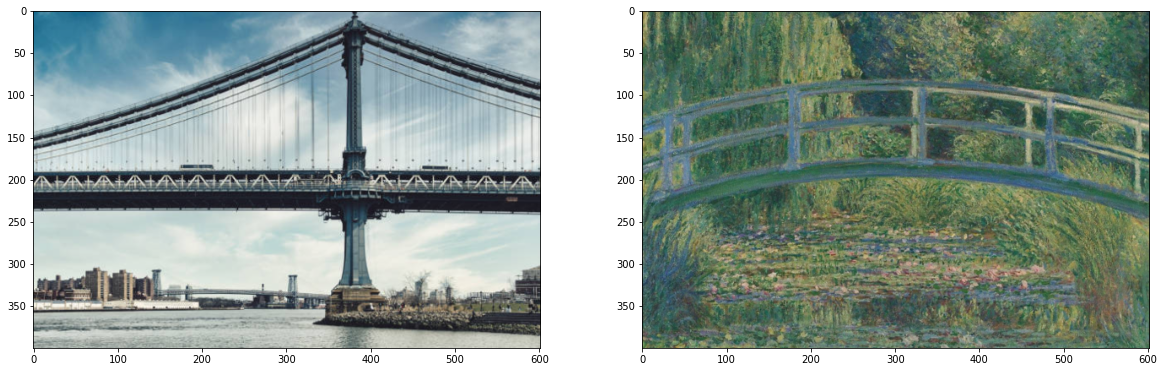

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

### <b> Content and Style Feature Layers </b>

In [ ]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """

    ## Need the layers for the content and style representations of an image
    if layers is None:
        layers = {'0': 'conv1_1',
                '5': 'conv2_1',
                '10': 'conv3_1',
                '19': 'conv4_1',
                '21': 'conv4_2',    ## Content representation
                '28': 'conv5_1'}

    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features

### <b> Gram Matrix </b>

In [ ]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor
    """

    ## get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()

    ## reshape it, so we're multiplying the features for each channel
    tensor = tensor.view(d, h*w)

    ## calculate the gram matrix
    gram = torch.mm(tensor, torch.t(tensor))

    return gram

In [ ]:
# Get the content and style features before forming the target
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# Calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# Create a third image. We are starting with the content image
target = content.clone().requires_grad_(True)

### <b> Loss and Weights </b>

In [ ]:
# weights for each style layer
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.8,
                 'conv3_1': 0.5,
                 'conv4_1': 0.3,
                 'conv5_1': 0.1}

# you may choose to leave these as is
content_weight = 0.01  # alpha
style_weight = 1e22  # beta

Total loss:  3.8973398173406576e+23


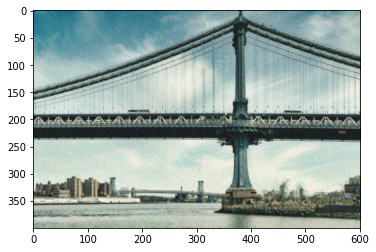

Total loss:  2.112544009607325e+23


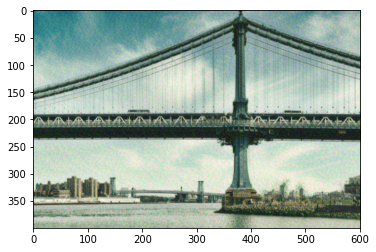

Total loss:  1.4448986054325533e+23


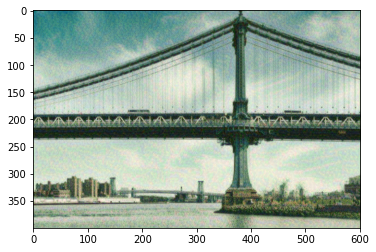

Total loss:  1.0993622658943583e+23


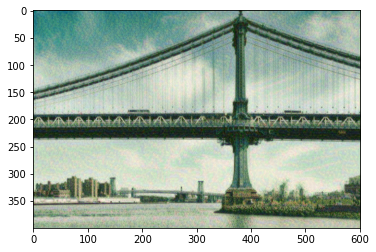

Total loss:  8.853504910257719e+22


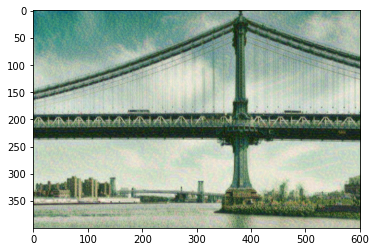

Total loss:  7.382574778403024e+22


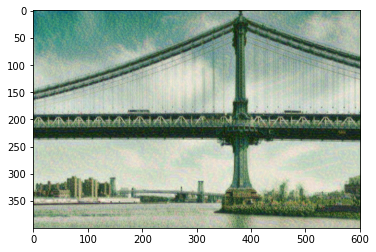

Total loss:  6.3021053831614625e+22


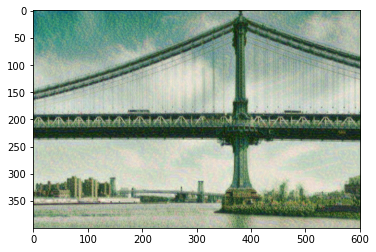

Total loss:  5.472554941878774e+22


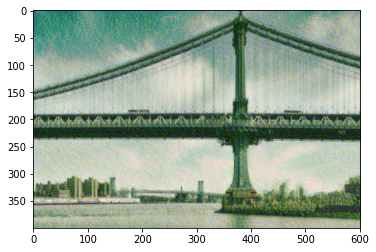

Total loss:  4.812967648373271e+22


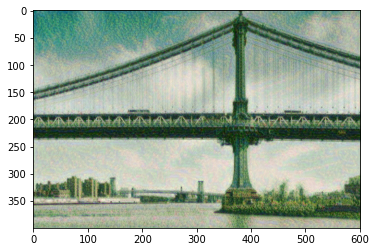

Total loss:  4.273364355420248e+22


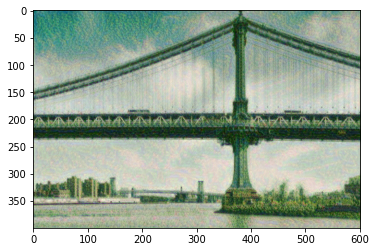

Total loss:  3.821966763329052e+22


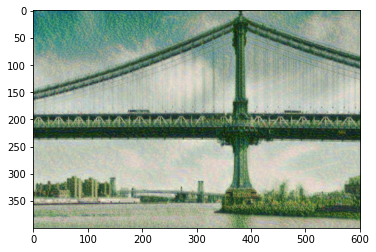

Total loss:  3.4377171661420063e+22


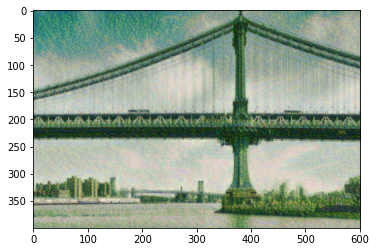

Total loss:  3.1059061319361744e+22


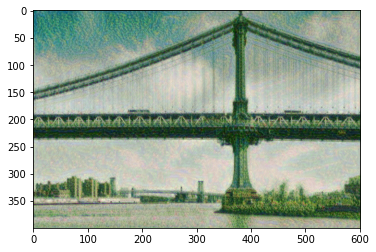

Total loss:  2.816855425112337e+22


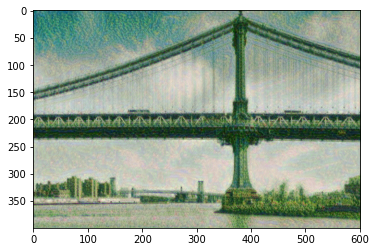

Total loss:  2.562795435593355e+22


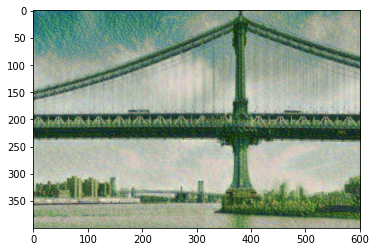

Total loss:  2.33806626454753e+22


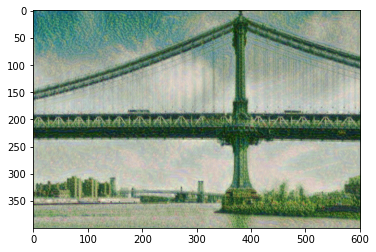

Total loss:  2.138197638984734e+22


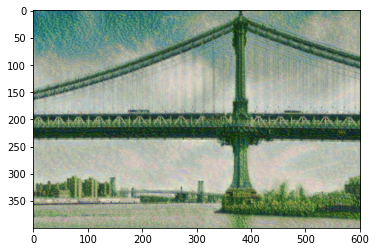

Total loss:  1.959511469089294e+22


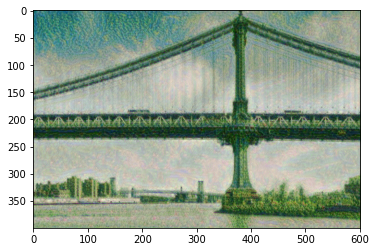

Total loss:  1.7990998931718074e+22


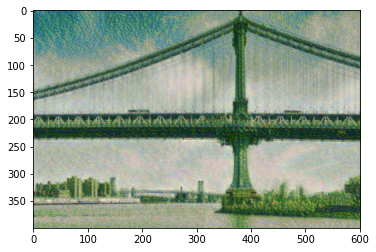

Total loss:  1.6546306095752495e+22


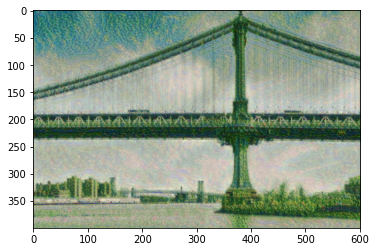

Total loss:  1.5243216565170606e+22


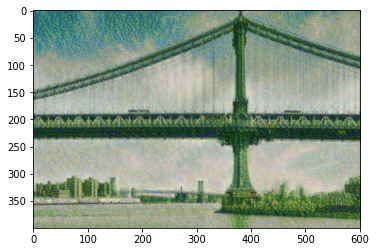

Total loss:  1.4064469168500603e+22


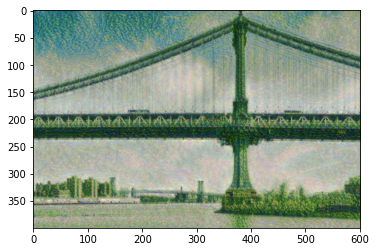

Total loss:  1.2994170702657495e+22


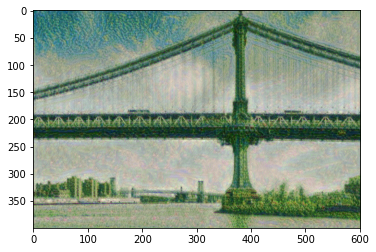

Total loss:  1.2021326755050964e+22


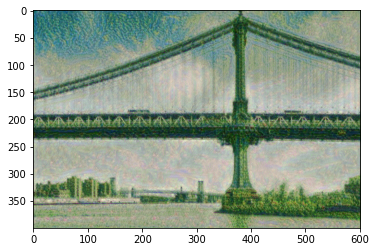

Total loss:  1.1135722035826227e+22


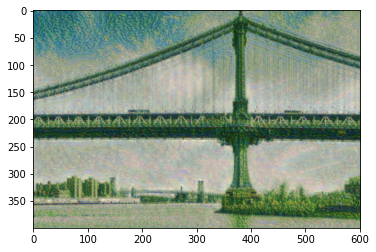

In [ ]:
# for displaying the target image, intermittently
show_every = 100

# iteration hyperparameters
optimizer = torch.optim.Adam([target], lr=0.003)
steps = 2500  # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):

    ## Get the features from your target image
    ## Then calculate the content loss
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # iterate through each style layer and add to the style loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape

        ## TODO:  get the "style" style representation
        style_gram = style_grams[layer]

        ## TODO: Calculate the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer]*torch.mean((target_gram - style_gram)**2)

        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)

        # At the end of this nested for loop, we have the style loss for all the layers added up

    ## Calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss

    ## -- do not need to change code, below -- ##
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

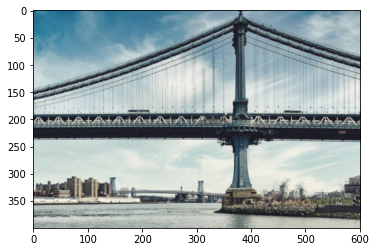

In [ ]:
plt.imshow(im_convert(content))